In [ ]:
import xml.etree.ElementTree as ET
from sklearn import feature_extraction
import sklearn as skl
from nltk.stem import RSLPStemmer
import nltk
from zipfile import ZipFile
import pandas as pd
import numpy as np
import unicodedata
import os
import re
import gensim
import scipy.sparse
from gensim.models import Word2Vec
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.regularizers import L2
from tensorflow.keras.layers import Dropout
from sklearn import model_selection
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

In [ ]:
# Caminho dos arquivos extraidos do kaggle
path_dataset = r'files\classificao-de-notcias.zip'
path_db = r'db'

# Caminho dos arquivos que serão utilizados para a atividade
path_train = r'db\arquivos_competicao\arquivos_competicao\train.csv'
path_test = r'db\arquivos_competicao\arquivos_competicao\test.csv'
path_news = r'db\arquivos_competicao\arquivos_competicao\news'


In [ ]:
def unzip(path, pathFolder):

    # descompacta a base de dados de notícias
    z = ZipFile(path, 'r')

    if os.path.isdir(pathFolder):
        z.extractall(pathFolder)
        z.close()
    else:
        os.mkdir(pathFolder)
        z.extractall(pathFolder)
        z.close()

    print("Arquivo descompactado com sucesso!")

# Antes de descompactar os arquivos valida se ja foram descompactados antes
if not os.path.isdir(path_news):
    unzip(path_dataset, path_db)
else:
    print("Arquivo já descompactado")

Arquivo já descompactado


---
## 1. Carregando os arquivos de teste e treino

In [ ]:
#Carregando os arquivos de treino
df_train = pd.read_csv(path_train)
print("Colunas do arquivo de treino: ", df_train.columns)
print("Quantidade de linhas: ", df_train.shape[0])

Colunas do arquivo de treino:  Index(['ID', 'Class'], dtype='object')
Quantidade de linhas:  2781


In [ ]:
# Carregando os arquivos de teste
df_teste = pd.read_csv(path_test)
print("Colunas do arquivo de treino: ", df_teste.columns)
print("Quantidade de linhas: ", df_teste.shape[0])

Colunas do arquivo de treino:  Index(['ID'], dtype='object')
Quantidade de linhas:  1193


---
## Pré-Processamento dos Dados


### Criando um DataFrame com os textos e titulos extraidos do XML
Para facilitar a aplicação dos metodos foi adicionando novas colunas no DataFrame de treino e teste, contendo o texto e titulo extraidos dos arquivos xml

In [ ]:
def extract_xml_text(path_xml):

    """
    A função `extract_xml_text` é designada para extrair os textos dos arquivos XML
    especificados pelo `path_xml`.
    Utilizando a biblioteca ElementTree para leitura do arquivo XML
    """

    # Instancia um objeto como uma árvore de análise
    tree = ET.parse(path_xml)

    # Obtem o elemento raiz da árvore de ánalise
    root = tree.getroot()

    # Encontra o elemento headline (titulo) dentro da árvore de analise
    headline = root.find('headline').text if root.find('headline') is not None else ''

    # Entroa todos os elementos <p> que na estrutura dos xml's contem o texto
    paragraphs = root.findall('.//p')

    # Junta em uma unica string, separando por espaços
    text = ' '.join([p.text for p in paragraphs if p.text is not None])

    return headline, text

def apply_extraction(df_applyed):

    """
    Essa função é responsável em aplicar as novas colunas
    no df_applyed passado como parametro.
    """

    # Loop pelas linhas do df
    for idx in df_applyed.index:

        # atribui o valor da coluna id na variavel file
        file = df_applyed.at[idx, 'ID']

        # Concatena o nome do arquivo com o caminho dele
        path_xml = f"{path_news}\{file}"

        # Extrai o texto e titulo desse arquivo
        titulo, texto = extract_xml_text(path_xml)

        #Atribui esses o texto e titulos em novas colunas
        df_applyed.at[idx, 'TITULO'] = titulo
        df_applyed.at[idx, 'TEXTO'] = texto

    return df_applyed

def print_porcentagem(target):
    # Calcula a contagem de cada classe
    class_counts = target['Class'].value_counts()

    # Calcula a porcentagem de cada classe
    class_percentages = class_counts / len(target) * 100

    # Imprime a porcentagem de cada classe
    for cl, pct in class_percentages.items():
        print(f"Porcentagem da classe {cl}: {round(pct, 2)}%")

def preprocessing_portuguese(text, stemming = False, stopwords = False):
    """
    Funcao usada para tratar textos escritos na lingua portuguesa

    Parametros:
        text: variavel do tipo string que contem o texto que devera ser tratado

        stemming: variavel do tipo boolean que indica se a estemizacao deve ser aplicada ou nao

        stopwords: variavel do tipo boolean que indica se as stopwords devem ser removidas ou nao
    """

    # Lower case
    text = text.lower()

    # remove os acentos das palavras
    nfkd_form = unicodedata.normalize('NFKD', text)
    text = u"".join([c for c in nfkd_form if not unicodedata.combining(c)])

    # remove tags HTML
    regex = re.compile('<[^<>]+>')
    text = re.sub(regex, " ", text)

    # normaliza as URLs
    regex = re.compile('(http|https)://[^\s]*')
    text = re.sub(regex, "<URL>", text)

    # normaliza emails
    regex = re.compile('[^\s]+@[^\s]+')
    text = re.sub(regex, "<EMAIL>", text)

    # converte todos os caracteres não-alfanuméricos em espaço
    regex = re.compile('[^A-Za-z0-9]+')
    text = re.sub(regex, " ", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+.[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+,[0-9]+')
    text = re.sub(regex, "NUMERO", text)

    # normaliza os numeros
    regex = re.compile('[0-9]+')
    text = re.sub(regex, "NUMERO", text)


    # substitui varios espaçamentos seguidos em um só
    text = ' '.join(text.split())

    # separa o texto em palavras
    words = text.split()

    # trunca o texto para apenas 200 termos
    words = words[0:200]

    # remove stopwords
    if stopwords:
        words = text.split() # separa o texto em palavras
        words = [w for w in words if not w in nltk.corpus.stopwords.words('portuguese')]
        text = " ".join( words )

    # aplica estemização
    if stemming:
        stemmer_method = RSLPStemmer()
        words = [ stemmer_method.stem(w) for w in words ]
        text = " ".join( words )

    # remove palavras compostas por apenas um caracter
    words = text.split() # separa o texto em palavras
    words = [ w for w in words if len(w)>1 ]
    text = " ".join( words )

    return text

In [ ]:
df_train = apply_extraction(df_train)
df_train = df_train[['ID', 'TITULO', 'TEXTO', 'Class']]
print_porcentagem(df_train)

Porcentagem da classe Mercados: 74.33%
Porcentagem da classe Economia: 21.18%
Porcentagem da classe GovSocial: 3.24%
Porcentagem da classe CorpIndustrial: 1.26%


In [ ]:
df_teste = apply_extraction(df_teste)
df_teste = df_teste[['ID', 'TITULO', 'TEXTO']]

### Tratando os textos da base de dados
- Aplicada a função de estemização para a linguagem dos textos (português)
- Removendo os ascentos das palavras
- Criando um limite de 200 temrmos por palavras, para evitar que a predição do classificador seja influenciada pelo tamanho da noticia.

In [ ]:
# Download the stopwords corpus
nltk.download('stopwords')

# Download the RSLPStemmer
nltk.download('rslp')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package rslp to
[nltk_data]     C:\Users\vitor\AppData\Roaming\nltk_data...
[nltk_data]   Package rslp is already up-to-date!


True

In [ ]:
# Aplicar a função ao DataFrame de treino
df_train['TEXTO'] = df_train['TEXTO'].apply(preprocessing_portuguese)

# Aplicando a função no df de teste
df_teste['TEXTO'] = df_teste['TEXTO'].apply(preprocessing_portuguese)

### Fazendo a divisão entre os dados de teste e treino

In [ ]:
# gera uma divisão dos dados em treino e teste
cv = skl.model_selection.StratifiedShuffleSplit(n_splits=1, train_size=0.8,
                                                random_state=10)

# retorna os índices de treino e teste
dataset = df_train['TEXTO']
target = df_train['Class']
train_index, test_index = list( cv.split(dataset, target) )[0]

# retorna as partições de treino e teste de acordo com os índices
dataset_train, dataset_test = dataset[train_index], dataset[test_index]
Y_train, Y_test = target[train_index], target[test_index]

print('Qtd. dados de treinamento: %d (%1.2f%%)' %(dataset_train.shape[0], (dataset_train.shape[0]/dataset.shape[0])*100) )
print('Qtd. de dados de teste: %d (%1.2f%%)' %(dataset_test.shape[0], (dataset_test.shape[0]/dataset.shape[0])*100) )

Qtd. dados de treinamento: 2224 (79.97%)
Qtd. de dados de teste: 557 (20.03%)


### Gerando a representação vetorial

Gerando a representação vetorial

Iremos transformar o texto em um vetor de atributos com valores numéricos. Uma das formas de fazer isso é considerar que cada palavra (ou token) da base de dados de treinamento é um atributo que armazena o número de vezes que uma determinada palavra aparece no texto. Na biblioteca `scikit-learn` podemos fazer essa conversão de texto para um vetor de atributos usando a função `skl.feature_extraction.text.CountVectorizer()`. Essa função gera um modelo de vetorização que pode ser ajustado com a base nos dados de treinamento usando a função `fit_transform()`.

Obs.: você deve treinar o modelo de representação **apenas com os dados de treinamento**.

In [ ]:
# inicializa o modelo usado para gerar a representação TF (term frequency)
vectorizer = skl.feature_extraction.text.CountVectorizer(analyzer = "word", tokenizer = None, preprocessor = None,
                                                         stop_words = None, lowercase = True, binary=False, dtype=np.int32)

# treina o modelo TF com os dados de treinamento e converte os dados de treinamento para uma array que contém a frequência dos termos em cada documento (TF - term frequency)
X_train_tf = vectorizer.fit_transform(dataset_train)

# converte os dados de teste
X_test_tf = vectorizer.transform(dataset_train)

print('20 primeiras palavras do vocabulário obtidas a partir dos dados de treinamento:\n')
print(vectorizer.get_feature_names_out()[0:20])

print('\nDimensão dos dados vetorizados: ', X_train_tf.shape)
print('\nDimensão dos dados vetorizados: ', X_test_tf.shape)

20 primeiras palavras do vocabulário obtidas a partir dos dados de treinamento:

['aa' 'aaa' 'aanumero' 'aas' 'abaixo' 'abaixos' 'abaixou' 'abalada'
 'abanadas' 'abanar' 'abandona' 'abandonado' 'abandonaram' 'abastecimento'
 'abatidas' 'abatimentos' 'aberta' 'abertamente' 'abertas' 'aberto']

Dimensão dos dados vetorizados:  (2224, 9506)

Dimensão dos dados vetorizados:  (2224, 9506)



## Gerando word embeddings

Depois de fazer o pré-processamento, é necessário transformar o texto em um vetor de atributos com valores numéricos. Podemos fazer isso usando word embeddings pré-treinadas ou treinando um modelo próprio.

Vamos passar por toda a base de dados e transformar cada documento em uma lista de palavra.

In [ ]:
dataset2_train = []
for i, msg in enumerate(dataset_train):
    dataset2_train.append(msg.split())

dataset2_test = []
for i, msg in enumerate(dataset_test):
    dataset2_test.append(msg.split())

print("\n\n20 primeiras palavras da primeira amostra de treino")
print(dataset2_train[0][0:30])

print("\n\n20 primeiras palavras da primeira amostra de teste")
print(dataset2_test[0][0:30])



20 primeiras palavras da primeira amostra de treino
['lisboa', 'NUMERO', 'mai', 'reuter', 'indice', 'de', 'precos', 'dos', 'bens', 'nao', 'transaccionaveis', 'foi', 'em', 'abril', 'de', 'NUMERO', 'pct', 'contra', 'NUMERO', 'pct', 'no', 'mes', 'de', 'marco', 'anunciou', 'hoje', 'instituto', 'nacional', 'de', 'estatistica']


20 primeiras palavras da primeira amostra de teste
['lisboa', 'NUMERO', 'jun', 'reuter', 'indice', 'de', 'precos', 'no', 'consumidor', 'ipc', 'devera', 'registar', 'uma', 'evolucao', 'moderada', 'apesar', 'de', 'em', 'maio', 'ipc', 'homologo', 'ter', 'invertido', 'tendencia', 'descendente', 'dos', 'meses', 'anteriores', 'refere', 'sintese']


Neste momento, vamos treinar modelo próprio de embeddings baseado nos dados de treinamento. Para manipular as embeddings, iremos usar a biblioteca Gensim: https://radimrehurek.com/gensim/models/word2vec.html

In [ ]:
sentencasEmbedding = dataset2_train
embeddingModel = Word2Vec(sentences = sentencasEmbedding,
                          vector_size = 200,
                          window = 3,
                          min_count = 1)

vocabSize = len(embeddingModel.wv)

print("\nTamanho do vocabulário do modelo: ", vocabSize)


Tamanho do vocabulário do modelo:  9507


### Gerando os vetroes para todos os documentos da base de dados

In [ ]:
def getDocvector(model, doc):
    """
    obtem o vetor de cada palavra de um documento e calcula um vetor medio
    """

    wordList = []
    for word in doc:

        try:
            vec = model.wv[word]
            wordList.append(vec)
        except:
            pass

    if len(wordList)>0:
        vetorMedio = np.mean( wordList, axis=0 )
    else:
        vetorMedio = np.zeros( model.wv.vector_size )

    return vetorMedio

In [ ]:
def dataset2featureMatrix(dataset, embeddingModel):

    X_embedding = []
    for doc in dataset:
        vec = getDocvector(embeddingModel, doc)
        X_embedding.append(vec)

    X_embedding = np.array(X_embedding)
    return X_embedding


X_train_embedding = dataset2featureMatrix(dataset2_train, embeddingModel)
X_test_embedding = dataset2featureMatrix(dataset2_test, embeddingModel)

print(X_train_embedding.shape)
print(X_test_embedding.shape)


(2224, 200)
(557, 200)


_______
# Treinando uma rede neural perceptron multicamadas (MLP - multi layer perceptron)

Como os vetores dos documentos gerados com os formatos TF, TF-IDF e binário possuem alta dimensionalidade, não convém usá-los para treinar o método MLP. O custo computacional para isso seria muito grande.

Mas, como os documentos representados por word embeddings possuem baixa dimensionalidade, podemos usá-los.

In [ ]:
# variável que deverá recer o modelo
model = None

input_layer_size  = X_train_embedding.shape[1]
hidden_layer_size = input_layer_size
output_layer_size = 1

In [ ]:
# Converta Y_train para um numpy array e reshape para (-1, 1) para usar com OneHotEncoder
Y_train = np.array(Y_train).reshape(-1, 1)

# Inicialize o OneHotEncoder
onehot_encoder = OneHotEncoder(sparse_output=False)

# Converta as classes para vetores binários
Y_train_encoded = onehot_encoder.fit_transform(Y_train)

# regularizacao
regularizacao = L2(0.1)

# ajusta a camada de entrada
input_layer_size = X_train_embedding.shape[1]
input_shape = (input_layer_size,)
print('Camada de entrada: ', input_shape)

# Configura o modelo de rede neural artificial
model = Sequential()

model.add(tf.keras.Input(shape=(input_layer_size,)))

model.add(Dense(hidden_layer_size,
                activity_regularizer = regularizacao,
                activation='relu')
         )

model.add(Dropout(0.1))

# Ajuste o número de saídas para o número de classes únicas e use softmax para a ativação
model.add(Dense(Y_train_encoded.shape[1], activation='softmax'))

# Finaliza a configuração do modelo e inicia o treinamento
optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

print(model.summary())

# Agora treine o modelo
history = model.fit(X_train_embedding, Y_train_encoded, epochs=500, batch_size=250, validation_split=0.2, verbose=0)

Camada de entrada:  (200,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 200)            │        40,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 200)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4)              │           804 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41,004 (160.17 KB)

 Trainable params: 41,004 (160.17 KB)

 Non-trainable params: 0 (0.00 B)

None


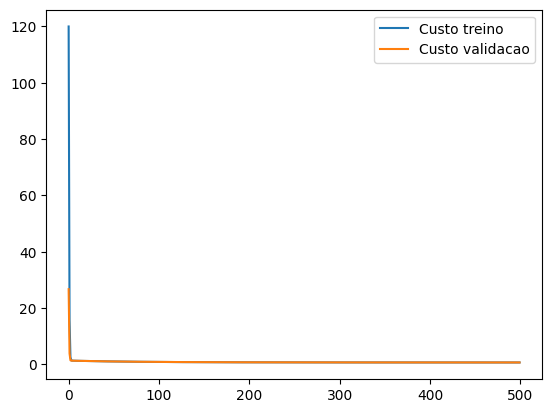

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
df = pd.DataFrame()
df['Custo treino'] = history.history['loss']
df['Custo validacao'] = history.history['val_loss']

df.plot()
plt.show()

In [ ]:
import numpy as np
import sklearn as skl
import sklearn.metrics

def predicao(model, X_test, Y_test):
    """
    Retorna as classes preditas e a acurácia
    """
    # Avalia o modelo
    test_results = model.evaluate(X_test, Y_test, verbose=0)
    acuracia = test_results[1]

    # Obtem a probabilidade de cada classe
    pred = model.predict(X_test)

    # Usa argmax para obter o índice da classe com maior probabilidade
    predClass = np.argmax(pred, axis=1)

    # Converte os rótulos de teste para o formato esperado
    Y_test_class = np.argmax(Y_test, axis=1)

    return predClass, acuracia, Y_test_class

# Obtem as classes
predClass, acuracia, Y_test_class = predicao(model, X_test_embedding, Y_test)

print('Acuracia: %1.3f' % acuracia)

# Obtem as medidas de desempenho
resultados = skl.metrics.classification_report(Y_test_class, predClass)

print(resultados)


ValueError: Arguments `target` and `output` must have the same shape. Received: target.shape=(None, 1), output.shape=(None, 4)